In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import preprocessing as skp
import os

In [3]:
import torch.nn as nn
import torch
import torch.utils.data as tdata

In [4]:
data = pd.read_csv(initial_path + 'data/Scores/PET/PET_SCORES.csv', sep=', ')
data.head(10)

C:\Users\RaulConchello\AppData\Local\Temp\ipykernel_24844\2218837524.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(initial_path + 'data/Scores/PET/PET_SCORES.csv', sep=', ')


,Long Sequence,Short Sequence,NET_E
0,LEU_TRP_SER_THR_ILE_LYS_GLN_LYS_GLY_ASN_VAL_ALA,LWSTIKQKGNVA,-11.62
1,LEU_TRP_SER_THR_ILE_VAL_GLN_LYS_GLY_ASN_VAL_ALA,LWSTIVQKGNVA,-11.94
2,LEU_TRP_SER_THR_ILE_VAL_GLN_ASP_GLY_ASN_VAL_ALA,LWSTIVQDGNVA,-12.31
3,LEU_TRP_VAL_THR_ILE_VAL_GLN_ASP_GLY_ASN_VAL_ALA,LWVTIVQDGNVA,-12.72
4,LEU_TRP_ALA_THR_ILE_VAL_GLN_ASP_GLY_ASN_VAL_VAL,LWATIVQDGNVV,-12.58
5,LEU_TRP_ALA_THR_ILE_ASP_GLN_VAL_GLY_ASN_VAL_VAL,LWATIDQVGNVV,-12.28
6,LEU_TRP_ALA_THR_ILE_ASP_THR_VAL_GLY_ASN_VAL_VAL,LWATIDTVGNVV,-12.53
7,LEU_TRP_ALA_THR_ILE_GLN_THR_VAL_GLY_ASN_VAL_VAL,LWATIQTVGNVV,-12.12
8,LEU_TRP_GLN_THR_ILE_GLN_THR_VAL_GLY_ASN_VAL_VAL,LWQTIQTVGNVV,-12.42
9,LEU_TRP_GLN_THR_ILE_GLN_THR_VAL_GLY_ASN_VAL_ALA,LWQTIQTVGNVA,-12.41


In [5]:
data.keys()

Index(['Long Sequence', 'Short Sequence', 'NET_E'], dtype='object')

In [6]:
sequences = data['Short Sequence'].to_list()
scores = data['NET_E'].to_list()

amino_acid_alphabet = ['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                       'M', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

encoder = skp.LabelEncoder()
encoder.fit(amino_acid_alphabet)

encoded_sequences = [torch.tensor(encoder.transform(list(seq))) for seq in sequences]

In [7]:
X = torch.stack(encoded_sequences)
Y = torch.tensor(scores)

# Split the data into training and test sets
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(len(Y), generator=generator)
split = lambda x, p: (x[:int(p*len(x))], x[int(p*len(x)):])
(X_train, X_test), (Y_train, Y_test) = split(X[indices], 0.8), split(Y[indices], 0.8)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# Create datasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, n_possible_amino_acids, embedding_dim):
        super(LSTMModel, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=n_possible_amino_acids, embedding_dim=embedding_dim)
        
        # LSTM layers
        self.lstm1 = nn.LSTM(embedding_dim, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.lstm3 = nn.LSTM(32, 32, batch_first=True)
        
        # Dense (fully connected) layer
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.embedding(x)
        
        x, _ = self.lstm1(x)  # Get the output tensor and discard the (h_n, c_n) tuple
        x, _ = self.lstm2(x)  # Same here
        x, _ = self.lstm3(x)  # And here
        
        x = self.fc(x)
        return x

# Initialize the model
model = LSTMModel(n_possible_amino_acids=len(amino_acid_alphabet), embedding_dim=12)

# Print the model architecture
print(model)

LSTMModel(
  (embedding): Embedding(18, 12)
  (lstm1): LSTM(12, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (lstm3): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
import torch.optim as optim

# 1. Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming a regression task; change if it's a different kind of task
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using the Adam optimizer; you can choose another if you prefer

# 2. Train the model
num_epochs = 2  # Define the number of epochs; you can adjust this value
model.train()  # Set the model to training mode

# Initialize lists to track losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    
    # Training loop (same as before)
    for i, (inputs, labels) in enumerate(train_dataloader):

        print(f"Batch {i+1}/{len(train_dataloader)}", end="\r")
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Print average training loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Print average validation loss for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}")
    
    model.train()

d:\Raul\Programs\envs\PennyLane\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/2], Training Loss: 243.70397673455838


d:\Raul\Programs\envs\PennyLane\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Raul\Programs\envs\PennyLane\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NameError: name 'val_dataloader' is not defined

In [ ]:
# Plotting the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

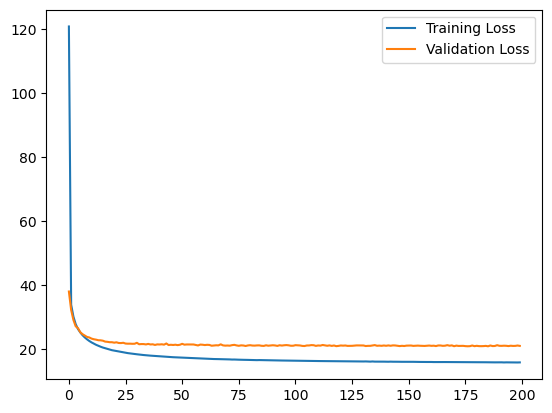

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
r2 = float(r2_score(y_test, y_pred))
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
print(r2)
print(rmse)

0.8248369390528172
4.575744403987374


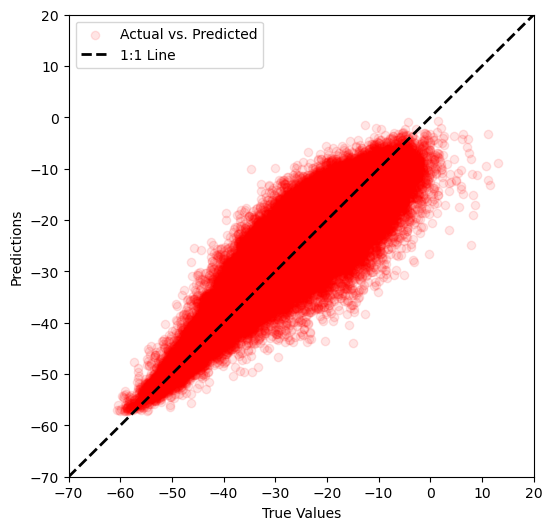

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='r', label='Actual vs. Predicted', alpha=0.1)
plt.plot([-70, 20], [-70, 20], 'k--', lw=2, label='1:1 Line')
plt.xlim(-70, 20)
plt.ylim(-70, 20)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
        
# with open('training_history.pkl', 'rb') as f:
#     loaded_training_history = pickle.load(f)

In [ ]:
np.save('./y_pred.npy', y_pred)